In [33]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Set the font family to Tahoma
plt.rcParams['font.family'] = 'Tahoma'

In [3]:
# Dictionary to map Thai month abbreviations to month numbers
thai_months = {
    "ม.ค.": 1,
    "ก.พ.": 2,
    "มี.ค.": 3,
    "เม.ย.": 4,
    "พ.ค.": 5,
    "มิ.ย.": 6,
    "ก.ค.": 7,
    "ส.ค.": 8,
    "ก.ย.": 9,
    "ต.ค.": 10,
    "พ.ย.": 11,
    "ธ.ค.": 12
}

def convert_thai_date(thai_date):
    # Split the input string
    thai_month_abbr, buddhist_year = thai_date.split("-")
    
    # Convert the Thai month abbreviation to a month number
    month = thai_months[thai_month_abbr.strip()]
    
    # Convert the Buddhist year to Gregorian year
    year = int(buddhist_year.strip())
    if year >= 75:
        year += 1900
    else:
        year += 2000
    # Use the first day of the month for the conversion
    day = 1
    
    # Create a datetime object
    date = datetime(year, month, day)
    
    # Return the formatted date in "Y-M-d" format
    return date.strftime("%Y-%m-%d")

In [4]:
df = pd.read_csv('./Table_PBV.csv', skiprows=3)
df['SET'] = df['SET'].str.replace(',', '')

set_index = pd.read_csv('./Table_Index.csv', skiprows=3)
set_index['SET'] = set_index['SET'].str.replace(',', '')

In [5]:
# set_index['Month-Year'].head(50)

In [6]:
df['SET'] = pd.to_numeric(df['SET'], errors='coerce')
set_index['SET'] = pd.to_numeric(set_index['SET'], errors='coerce')

In [7]:
selected_df = df[['Month-Year', 'SET']].dropna(axis=0)[::-1].copy()
set_index = set_index[['Month-Year', 'SET']].dropna(axis=0)[::-1].copy()

In [8]:
selected_df['Month-Year'] = selected_df['Month-Year'].apply(convert_thai_date)
selected_df['Month-Year'] = pd.to_datetime(selected_df['Month-Year'])

set_index['Month-Year'] = set_index['Month-Year'].apply(convert_thai_date)
set_index['Month-Year'] = pd.to_datetime(set_index['Month-Year'])

In [9]:
selected_df.set_index('Month-Year', inplace=True)
set_index.set_index('Month-Year', inplace=True)

In [10]:
selected_df['set-index'] = set_index

In [11]:
selected_df

,SET,set-index
Month-Year,,
1988-04-01,3.07,413.91
1988-05-01,3.16,424.93
1988-06-01,3.52,452.70
1988-07-01,3.51,457.01
1988-08-01,3.33,436.55
...,...,...
2024-02-01,1.33,1370.67
2024-03-01,1.33,1377.94
2024-04-01,1.32,1367.95


In [12]:
selected_df['log-SET'] = np.log(selected_df['SET'])

In [13]:
# selected_df['SET'][::-1].cumprod()** (1 / np.arange(1, len(selected_df)+1))
selected_df['gmean-SET'] = np.exp(selected_df['log-SET'].cumsum() / np.arange(1, len(selected_df)+1))

In [14]:
selected_df['scaled-SET'] = selected_df['SET'] / selected_df['gmean-SET'].shift()

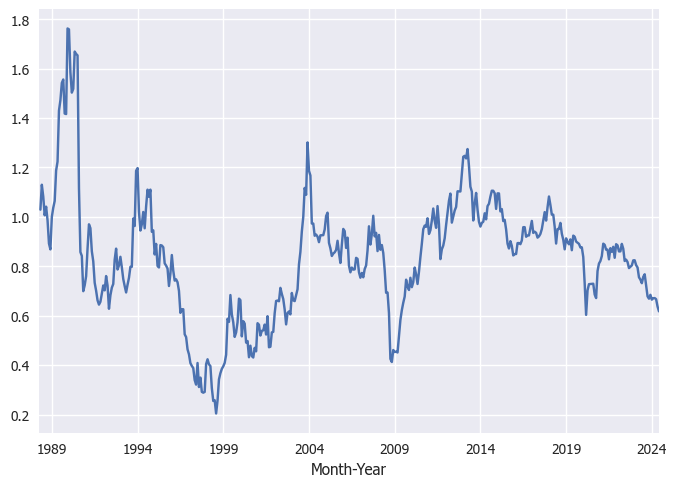

In [15]:
selected_df['scaled-SET'].plot();

In [16]:
n = 4
selected_df['quarter'], bins = pd.qcut(selected_df['scaled-SET'], q=n, labels=False, retbins=True)

In [17]:
bins

array([0.20427023, 0.68825346, 0.85390345, 0.96067702, 1.76269296])

In [18]:
selected_df['ret'] = selected_df['set-index'].pct_change()

In [19]:
# m = 100000
# d = 12

# for i in range(n):
#     years_to_filter  = selected_df[
#         (selected_df.index.month == 1) & (selected_df['quarter'] == i)
#         ].index.year
#     mask = selected_df.index.year.isin(years_to_filter)
    
#     bootstrapping_sample = np.random.choice(selected_df[mask]['ret'], size=(m, d), replace=True) + 1
    
#     ret_rest = np.prod(bootstrapping_sample, axis=1)
    
#     plt.hist(ret_rest, bins=100)
#     plt.title(f'Class:{i}\nGrowth: {np.median(ret_rest):.2f}\n5th: {np.quantile(ret_rest, 0.05):.2f}\n95th: {np.quantile(ret_rest, 0.95):.2f}')
#     plt.show()

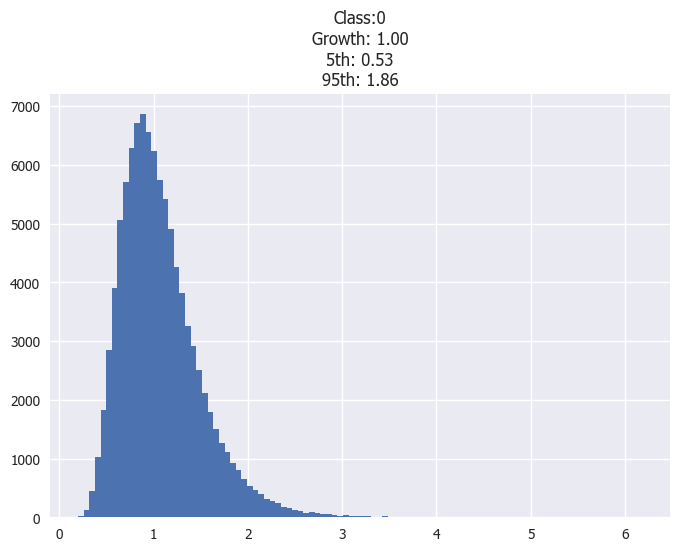

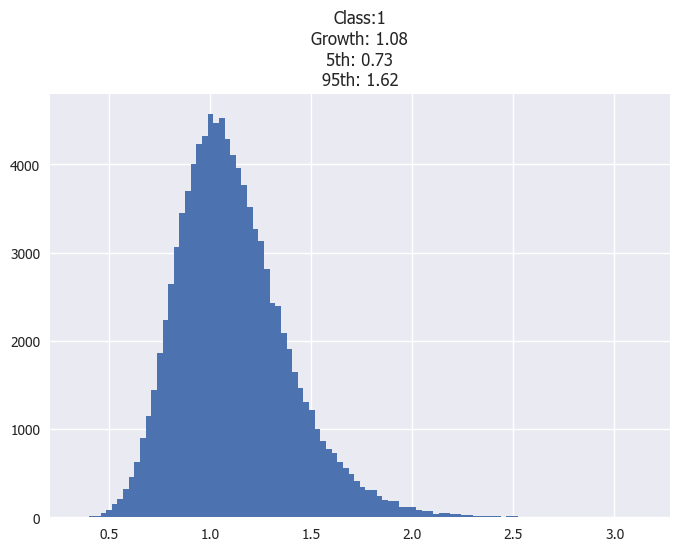

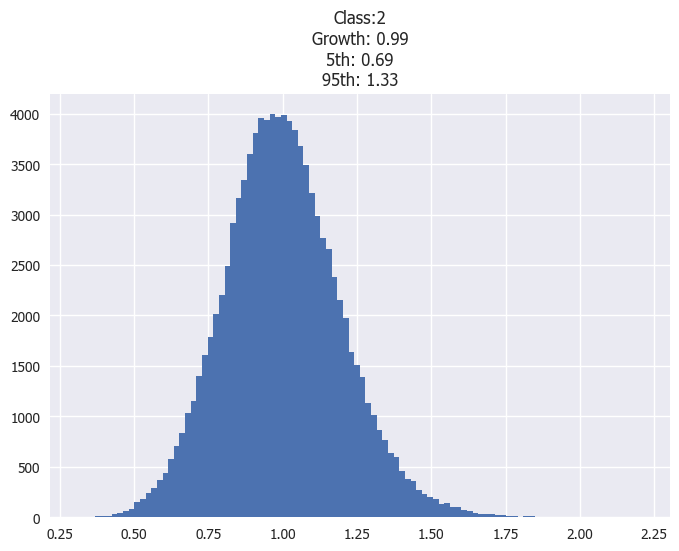

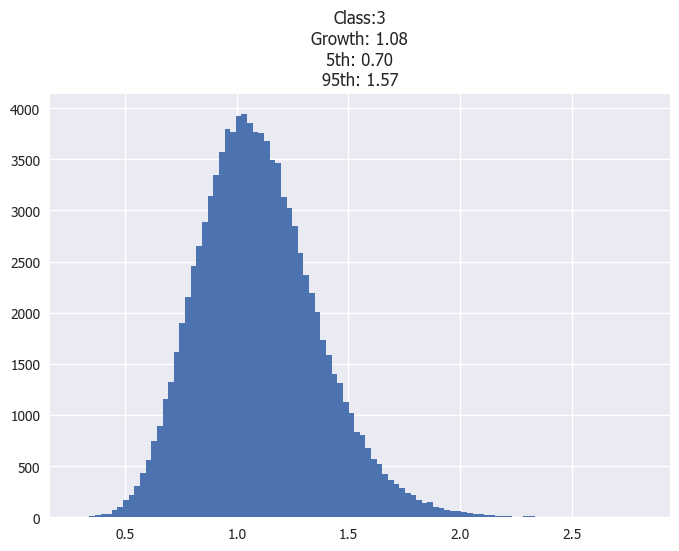

In [44]:
m = 100000
d = 12

for i in range(n):

    mask_index = selected_df[selected_df['quarter'] == i].index
    rets = []
    for mi in mask_index:
        rets += selected_df.loc[mi: mi + pd.DateOffset(months=11)]['ret'].tolist()
    
    bootstrapping_sample = np.random.choice(rets, size=(m, d), replace=True) + 1
        
    ret_rest = np.prod(bootstrapping_sample, axis=1)
    
    plt.hist(ret_rest, bins=100)
    plt.title(f'Class:{i}\nGrowth: {np.median(ret_rest):.2f}\n5th: {np.quantile(ret_rest, 0.05):.2f}\n95th: {np.quantile(ret_rest, 0.95):.2f}')
    plt.show()